# Emotion Detection from scratch

**Author:** Himanshu Atri <br>
**Description:** Training an image classifier from scratch on the Kaggle FER-2013 Dataset.


# Data Set

Kaggle - https://www.kaggle.com/datasets/msambare/fer2013
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)


# **Importing Data**

In [1]:
!kaggle datasets download -d msambare/fer2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 96% 58.0M/60.3M [00:03<00:00, 24.4MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.0MB/s]


In [2]:
!unzip fer2013.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

# **Importing packages**

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imghdr
import tensorflow as tf
import pickle
from google.colab import drive
import shutil

from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# **Setting up directories to save model**

In [4]:
# main directory where all models are going to be saved
project_name = "Emotion Detection Models"

# subdirectories for each model
models = [
  "Custom Model From Scratch",
  "Custom Model with Image augmentation",
  "Transfer Learning VGG16 Model",
  "Custom Model with Image augmentation",
  "Transfer Learning ResNet50 Model"
]

# creating all these sub directories
for model in models:
  path = os.path.join(project_name, model)
  os.makedirs(path, exist_ok=True)


# **Data Cleaning**

In [5]:
def remove_non_image_files(path):

  # acceptable image formats
  img_formats = ["jpg", "png", "jpeg"]

  for dir_path, dir, files in os.walk(path):
    # print(dir_path) # path of the current directory
    # print(dir) # name of all directory in the current directory
    # print(files) # name of all the files in current folder

    for file in files:
      file_path = os.path.join(dir_path, file)

      try:
        file_type = imghdr.what(file_path)
        if(file_type not in img_formats):
            os.remove(file_path)

      except Exception as e:
        print(e, "at file path ", file_path)



In [6]:
# for training data
remove_non_image_files("/content/train")

In [7]:
# for test data
remove_non_image_files("/content/test")

# **Data Analysis**

In [8]:
# for counting the number of images in each directory
def count_no_of_images(dir, dir_name):
  counts = {}

  for subdir in os.listdir(dir):
    path = os.path.join(dir, subdir)
    counts[subdir] = len(os.listdir(path))

  df = pd.DataFrame(counts, index=[dir_name])
  return df

In [9]:
train_df = count_no_of_images("/content/train/", "train")
test_df = count_no_of_images("/content/test/", "test")

<Axes: >

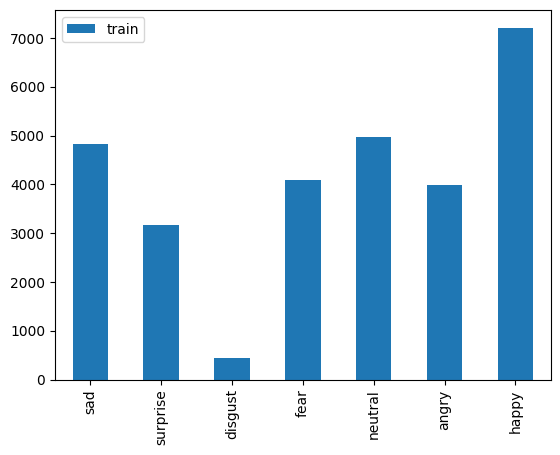

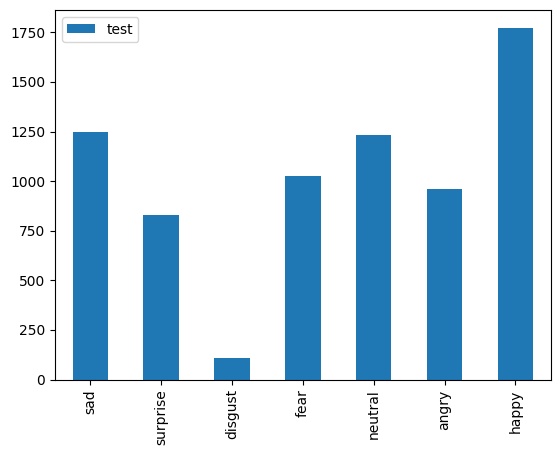

In [10]:
train_df.transpose().plot(kind="bar")
test_df.transpose().plot(kind="bar")

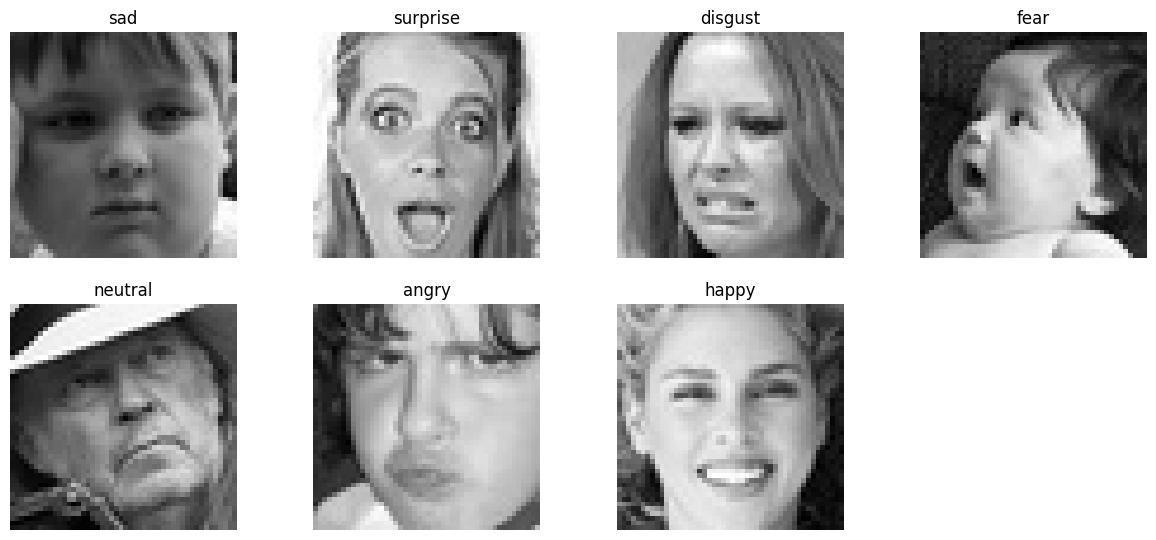

In [11]:
# plotting one image from each emotion
train_dir = "/content/train/"
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [12]:
# shape of image
img = cv2.imread("/content/train/angry/Training_10118481.jpg")
img.shape

(48, 48, 3)

# **Model 1: Custom Model From Scratch**

In [13]:
# initializing image generator

train_dir = "/content/train/"
test_dir = "/content/test/"

img_height, img_width = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

In [14]:
# rescaling the pixel values (0 - 255) to (0 -1)
data_generator = ImageDataGenerator(
    rescale = 1.0/255,
    validation_split = 0.2
)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)

validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale'

)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [15]:
class_label = train_generator.class_indices
class_label

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [16]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [17]:
model.compile(
    # tf.keras.optimizers.Adam
    optimizer=Adam(
        learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

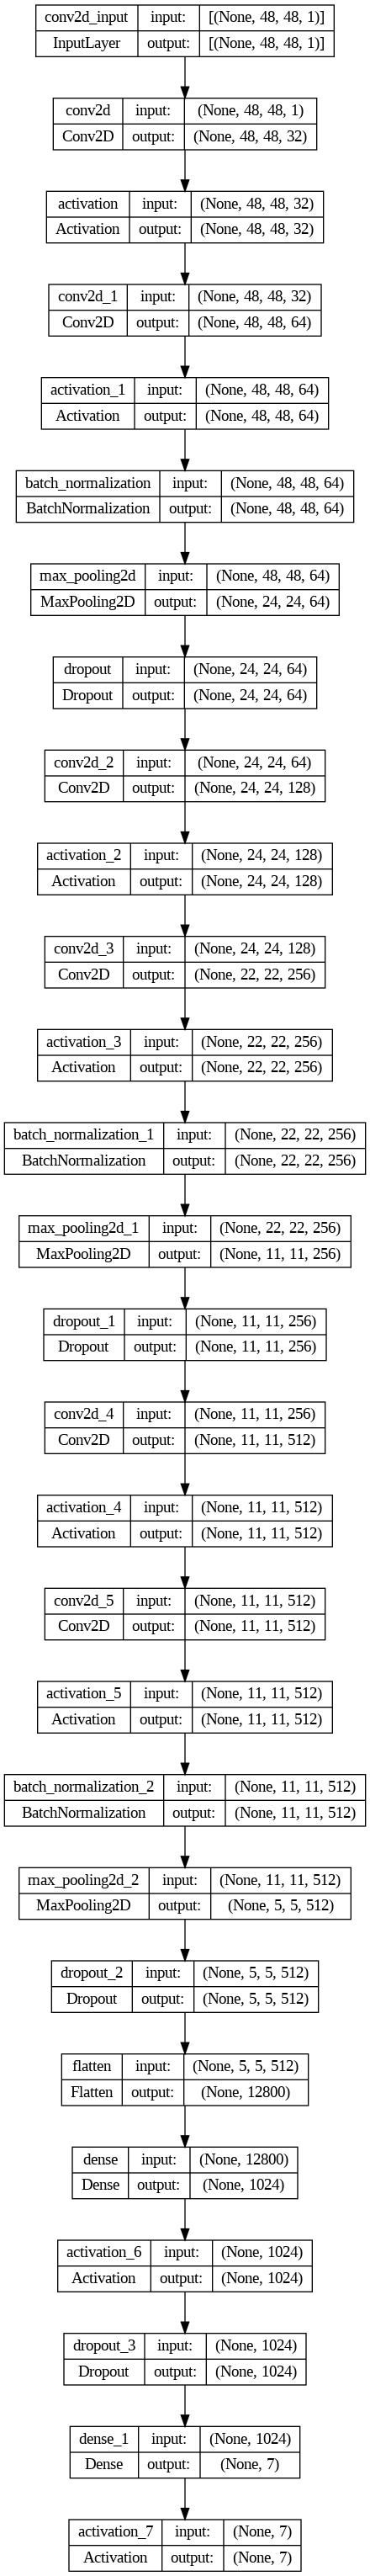

In [19]:
plot_model(model, to_file = '/content/Emotion Detection Models/Custom Model From Scratch/Architectures.png',
           show_shapes=True, show_layer_names=True)

# **Callbacks**

In [20]:
# file path to save the model
chk_path = "custom_cnn_model.keras"

In [21]:
# callback to save checkpoint
checkpoint = ModelCheckpoint(
    filepath=chk_path,
    save_best_only=True,
    verbose=1,
    mode='min',
    monitor='val_loss'
)

In [22]:
# callback for early stopping
earlystop = EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=3,
    min_delta=0,
    restore_best_weights=True
)

In [23]:
#callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001
)

In [24]:
#callback to log training data to a CSV file
csv_logger = CSVLogger("callback.log", separator=',', append=True)

In [25]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

In [26]:
# training the model
history = model.fit(
  train_generator,
  epochs=epochs,
  validation_data = validation_generator,
  callbacks=callbacks
)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.4017 - accuracy: 0.2600
Epoch 1: val_loss improved from inf to 15.52202, saving model to /content/Emotion Detection Models/Custom Model From Scratch/custom_cnn_model.keras
359/359 [==============================] - 38s 79ms/step - loss: 12.4017 - accuracy: 0.2600 - val_loss: 15.5220 - val_accuracy: 0.1730 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 10.1435 - accuracy: 0.3487
Epoch 2: val_loss improved from 15.52202 to 9.59385, saving model to /content/Emotion Detection Models/Custom Model From Scratch/custom_cnn_model.keras
359/359 [==============================] - 28s 78ms/step - loss: 10.1435 - accuracy: 0.3487 - val_loss: 9.5938 - val_accuracy: 0.3574 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 8.1113 - accuracy: 0.3914
Epoch 3: val_loss improved from 9.59385 to 7.34752, saving model to /content/Emotion Detection Models/Custo

# **Uploading the model and callback log on google drive**

In [27]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# Source path
model_path = 'custom_cnn_model.keras'
callback_path = 'callback.log'

# Destination path (where we want to save the model in Google Drive)
destination_path = '/content/drive/MyDrive/cnn_model_emotion_detection/custom_cnn_model.keras'
destination2_path = '/content/drive/MyDrive/cnn_model_emotion_detection/custom_cnn_callback.log'

# Copy the model file to Google Drive
shutil.copy(model_path, destination_path)
shutil.copy(callback_path, destination2_path)

print(f'Model saved to {destination_path} and callback saved to {destination2_path}')

Model saved to /content/drive/MyDrive/cnn_model_emotion_detection/custom_cnn_model.keras and callback saved to /content/drive/MyDrive/cnn_model_emotion_detection/custom_cnn_callback.log


In [29]:
#Unmount Google Drive
drive.flush_and_unmount()

# Plotting Model Performance

In [35]:
# function to plot graphs of accuracy and loss of model (useful with object of history)
def plot_history(history):
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  no_of_epochs = range(len(train_accuracy))

  plt.figure(figsize=(20, 5))

  # plotting accuracy
  plt.subplot(1,2,1)
  plt.plot(no_of_epochs, train_accuracy, label="Train Accuracy")
  plt.plot(no_of_epochs, val_accuracy, label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.title("Accuracy of Model")

  #plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(no_of_epochs, train_loss, label="Train Loss")
  plt.plot(no_of_epochs, val_loss, label="Validation Loss")
  plt.legend(loc="upper right")
  plt.title("Loss of Model")

  plt.show()


In [36]:
# function to plot graphs of accuracy and loss of model (useful with log of callback of history)
def plot_callback_history(log):
  train_accuracy = log['accuracy']
  val_accuracy = log['val_accuracy']

  train_loss = log['loss']
  val_loss = log['val_loss']

  no_of_epochs = range(len(train_accuracy))

  plt.figure(figsize=(20, 5))

  # plotting accuracy
  plt.subplot(1,2,1)
  plt.plot(no_of_epochs, train_accuracy, label="Train Accuracy")
  plt.plot(no_of_epochs, val_accuracy, label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.title("Accuracy of Model")

  #plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(no_of_epochs, train_loss, label="Train Loss")
  plt.plot(no_of_epochs, val_loss, label="Validation Loss")
  plt.legend(loc="upper right")
  plt.title("Loss of Model")

  plt.show()


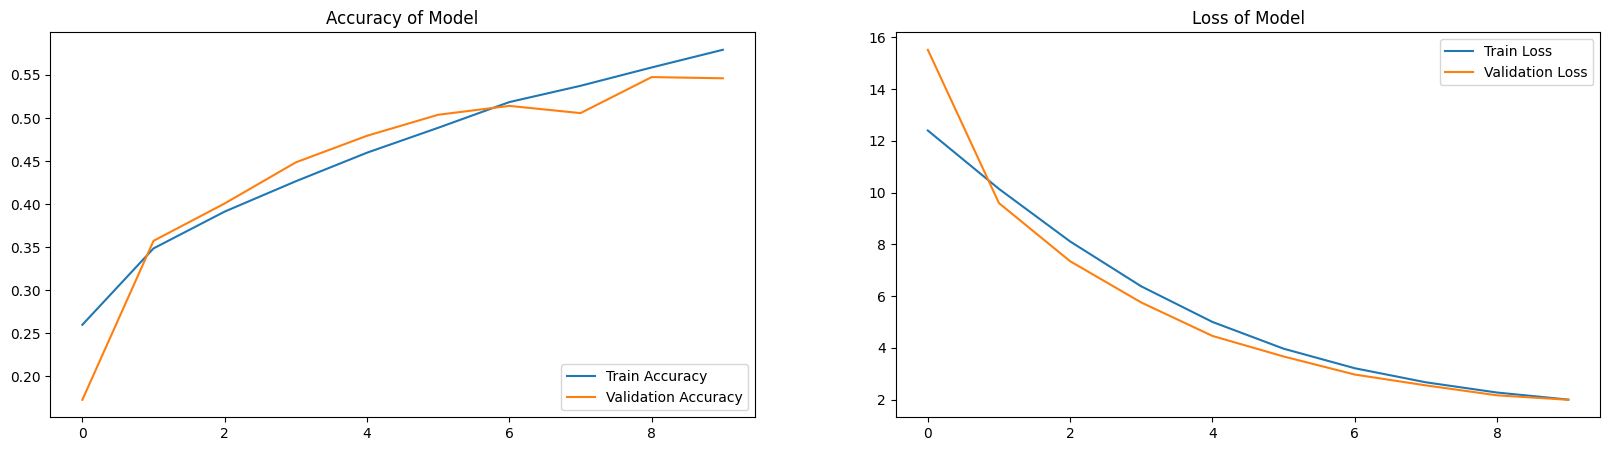

In [37]:
plot_callback_history(history)

# **Model Evaluation**

In [38]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 27ms/step - loss: 1.9795 - accuracy: 0.5588
final train accuracy = 62.77 , validation accuracy = 55.88


113/113 [==============================] - 3s 22ms/step


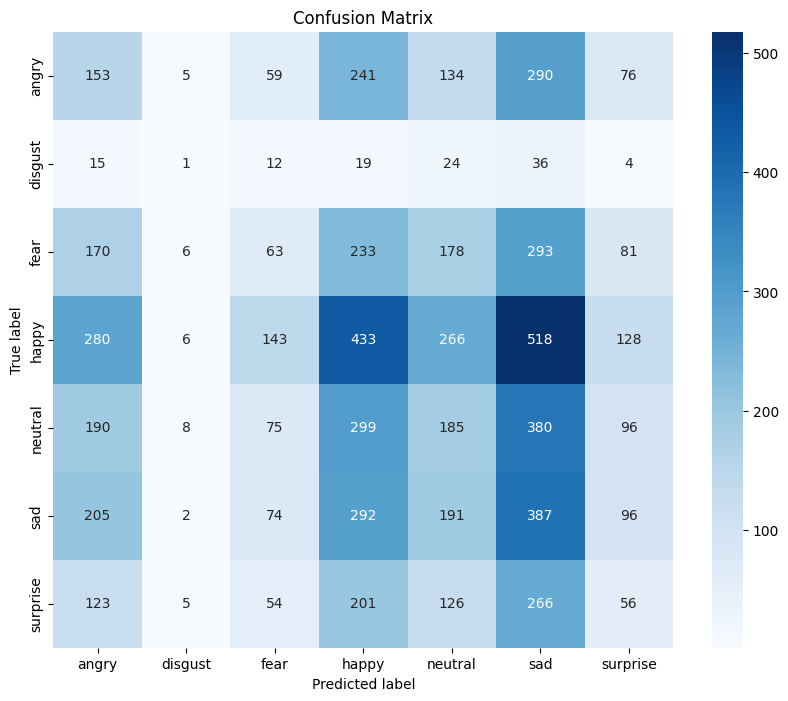

In [39]:
# plotting confusion matrix
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.16      0.15       958
     disgust       0.03      0.01      0.01       111
        fear       0.13      0.06      0.08      1024
       happy       0.25      0.24      0.25      1774
     neutral       0.17      0.15      0.16      1233
         sad       0.18      0.31      0.23      1247
    surprise       0.10      0.07      0.08       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



# **Making Predictions**

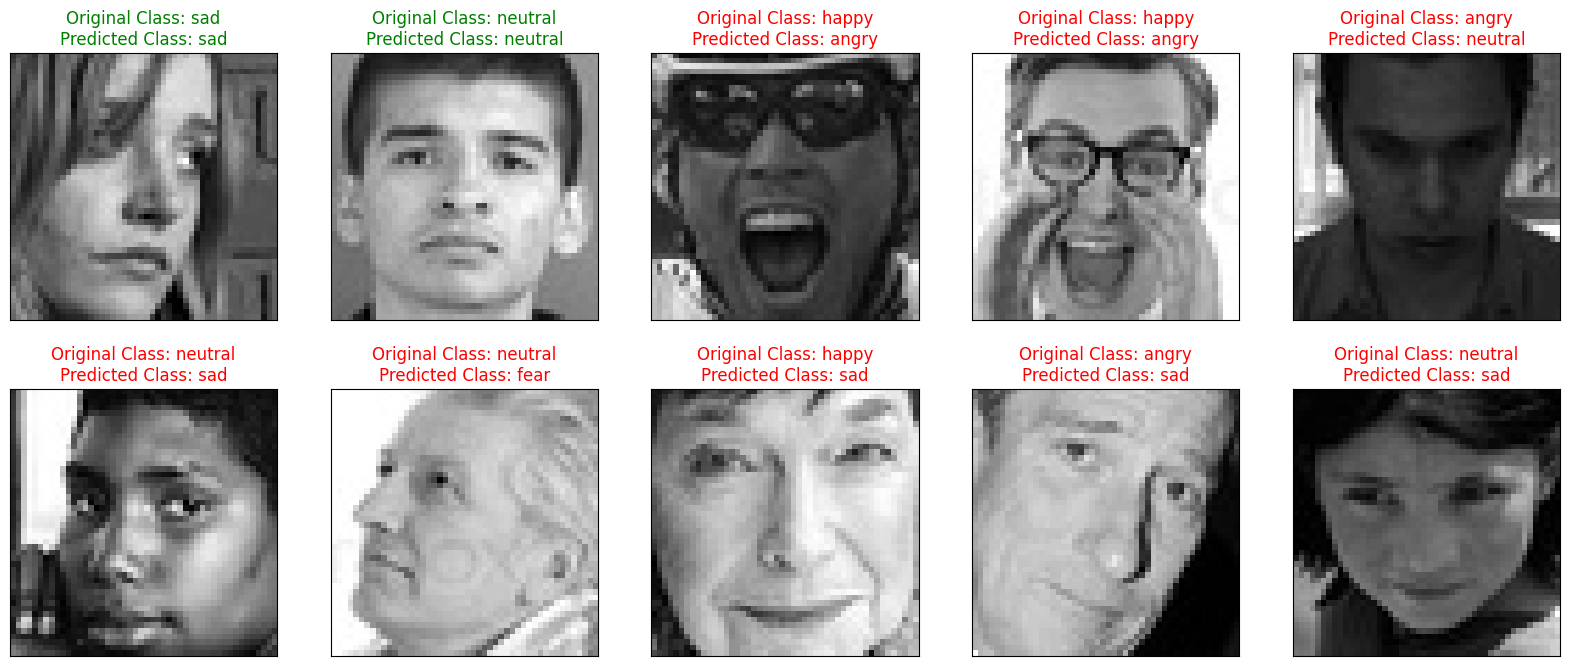

In [41]:
# classes of dataset
classes_dict = train_generator.class_indices
classes = np.array(list(classes_dict.keys()))

# batch_size
batch_size = test_generator.batch_size

# selecting a random batch
random_batch = np.random.randint(0, len(test_generator) - 1)

random_image_index = np.random.randint(0, batch_size, 10)

#plotting the images
fig, axis = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), subplot_kw={'xticks': [], 'yticks': []})
i=0;
for img_index in random_image_index:
  i += 1
  img_array = test_generator[random_batch][0][img_index]
  img_class_index  = np.argmax(test_generator[random_batch][1][img_index])
  img_class = classes[img_class_index]

  model_prediction = np.argmax(model.predict(tf.expand_dims(img_array, axis=0), verbose=0))
  predicted_class = classes[model_prediction]
  plt.imshow(img_array, cmap='gray')
  color = "green" if(img_class == predicted_class) else "red"
  plt.title(f"Original Class: {img_class}\nPredicted Class: {predicted_class}", color=color)

  plt.subplot(2, 5, i)

plt.show()

